In [6]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import sklearn
from sklearn.datasets import load_digits
import torch
import torchvision.datasets

In [7]:
# GLOBALS
BATCH_SIZE = 1000
DATA_FOLDER = 'data'

In [5]:
from sklearn.datasets import fetch_openml # MNIST data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [12]:
def torch_data_loading(batch_size=BATCH_SIZE):
    print('Loading dataset...')
    train_dataset = torchvision.datasets.MNIST(root=DATA_FOLDER, train=True,
                                               transform=torchvision.transforms.ToTensor(), download=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_dataset = torchvision.datasets.MNIST(root=DATA_FOLDER, train=False,
                                              transform=torchvision.transforms.ToTensor(), download=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    print("Done loading!")
    return train_dataset, train_loader, test_dataset, test_loader

In [13]:
train_dataset, train_loader, test_dataset, test_loader = torch_data_loading()

Loading dataset...
Done loading!


5


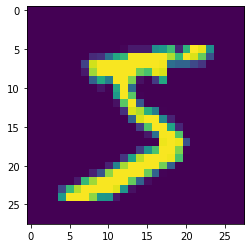

In [30]:
print(train_dataset[0][1])
plt.imshow(train_dataset[0][0][0])

In [51]:
import torch.nn.functional as F
import torch.nn as nn

class FFNNet(nn.Module):

    def __init__(self):
        super(FFNNet, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1 * 28 * 28, 120, bias=False)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x)) # view is ~ reshape
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [90]:
net = FFNNet()
print(net)
with torch.no_grad():
    num_params = [len(el.numpy().flatten()) for el in list(net.parameters())]
    print("There are {} parameters in our network".format(np.sum(num_params)))

FFNNet(
  (fc1): Linear(in_features=784, out_features=120, bias=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
There are 105094 parameters in our network


In [53]:
loss_function = nn.CrossEntropyLoss()


# Training loop hyperparameters
epochs = 10
learning_rate = 0.001

# Choose an optimizer or create one
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
########inputs, labels = data[0].to(device), data[1].to(device)  # what to send to deive? the Dataset object? 
print(device)

cpu


In [55]:
def report_test_error():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            samples, labels = data
            outputs = net(samples)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %d %%' % (total, (100 * correct / total)))

In [56]:
for epoch in range(epochs):       # loop over the dataset multiple times
    print(epoch)
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data  # get the inputs; data is a list of [inputs, labels]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 9
            print('Epoch: %d, batch: %5d, loss: %.3f' %
                  (epoch, i + 1, running_loss))
            report_test_error()
            running_loss = 0.0

0
Epoch: 0, batch:    10, loss: 13.491
Accuracy of the network on the 10000 test images: 75 %
Epoch: 0, batch:    20, loss: 13.368
Accuracy of the network on the 10000 test images: 76 %
Epoch: 0, batch:    30, loss: 12.908
Accuracy of the network on the 10000 test images: 76 %
Epoch: 0, batch:    40, loss: 12.830
Accuracy of the network on the 10000 test images: 77 %
Epoch: 0, batch:    50, loss: 12.475
Accuracy of the network on the 10000 test images: 77 %
Epoch: 0, batch:    60, loss: 11.846
Accuracy of the network on the 10000 test images: 77 %
1
Epoch: 1, batch:    10, loss: 11.692
Accuracy of the network on the 10000 test images: 77 %
Epoch: 1, batch:    20, loss: 11.635
Accuracy of the network on the 10000 test images: 78 %
Epoch: 1, batch:    30, loss: 11.211
Accuracy of the network on the 10000 test images: 78 %
Epoch: 1, batch:    40, loss: 11.205
Accuracy of the network on the 10000 test images: 78 %
Epoch: 1, batch:    50, loss: 10.888
Accuracy of the network on the 10000 te

Our network thinks this is a 7
The true label is 7


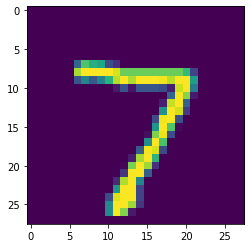

In [78]:
with torch.no_grad():
    correct_label = test_dataset[0][1]
    prediction = net(test_dataset[0][0])
    print("Our network thinks this is a {}".format(np.argmax(prediction.numpy()[0])))
    print("The true label is " + str(correct_label))
    plt.imshow(test_dataset[0][0][0])
